
# **EXPERIMENT 2: Use Swarm + Haystack to test Multi-Agentic Environment**

# 1. Introduction
- This experiment is designed to test the multi-agentic environment of the Swarm + Haystack framework.

## Tasks
- Implement Sample Orchestrator and Research Agent.
- Test Basic Tooling.
- Understand feasibility of work in using Swarm.
- Test if Swarm locks to OpenAI LLMs.

# 2. Setup Phase

In [1]:
! pip install -U openai haystack-ai duckduckgo-api-haystack python-dotenv jsonschema trafilatura

### Load `.env` file

In [2]:
from dotenv import load_dotenv

load_dotenv() # Load environment variable (OPENAI_API_KEY) from .env file 

True

### Import Packages

In [3]:
from typing import Annotated, Callable, Tuple
from dataclasses import dataclass, field

import random, re

from haystack.dataclasses import ChatMessage, ChatRole
from haystack.tools import create_tool_from_function
from haystack.components.tools import ToolInvoker
from haystack.components.generators.chat import OpenAIChatGenerator

In [4]:
from haystack import Pipeline
from haystack.utils import Secret
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument
from haystack.components.generators import OpenAIGenerator
from duckduckgo_api_haystack import DuckduckgoApiWebSearch

### Mermaid Function

In [5]:
import base64
from IPython.display import display_svg
from urllib.request import Request, urlopen

def mm(graph):
    graphbytes = graph.encode("ascii")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    url="https://mermaid.ink/svg/" + base64_string
    req=Request(url, headers={'User-Agent': 'IPython/Notebook'})
    display_svg(urlopen(req).read().decode(), raw=True)

# 3. Agent Setup

Since, we are only testing the feasibility of the framework. We'll take two functional agent and an additional dummy agent, to create a heirarchial agent setup.

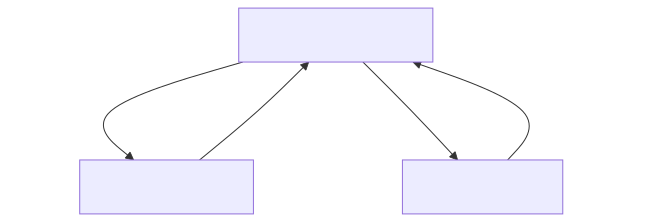

In [6]:
mm("""
   graph TD
    A[Orchestrator Agent] -->|Delegates tasks to| B[Research Agent]
    A -->|Manages| C[Dummy Agent]
    B -->|Performs research and provides insights| A
    C -->|Idle or placeholder agent| A
""")

### Orchestrator Agent

Coordinate workflow, Answer general questions, manage inter-agent communication, and finalize outputs.

### Research Agent
Investigate the industry/company, trends, competitors, and market dynamics.

### Dummy Agent
Act as a placeholder, to help test the handsoff.

# 4. Implementation

## Swarm Agent & Handoff Defination 

In [7]:
HANDOFF_TEMPLATE = "Transferred to: {agent_name}. Adopt persona immediately."
HANDOFF_PATTERN = r"Transferred to: (.*?)(?:\.|$)"


@dataclass
class SwarmAgent:
    name: str = "SwarmAgent"
    llm: object = OpenAIChatGenerator(model="gpt-4o-mini")
    instructions: str = "You are a helpful Agent"
    functions: list[Callable] = field(default_factory=list)

    def __post_init__(self):
        self._system_message = ChatMessage.from_system(self.instructions)
        self.tools = [create_tool_from_function(fun) for fun in self.functions] if self.functions else None
        self._tool_invoker = ToolInvoker(tools=self.tools, raise_on_failure=False) if self.tools else None

    def run(self, messages: list[ChatMessage]) -> Tuple[str, list[ChatMessage]]:
        # generate response
        agent_message = self.llm.run(messages=[self._system_message] + messages, tools=self.tools)["replies"][0]
        new_messages = [agent_message]

        if agent_message.text:
            print(f"\n{self.name}: {agent_message.text}")

        if not agent_message.tool_calls:
            return self.name, new_messages

        # handle tool calls
        for tc in agent_message.tool_calls:
            # trick: Ollama do not produce IDs, but OpenAI and Anthropic require them.
            if tc.id is None:
                tc.id = str(random.randint(0, 1000000))
        tool_results = self._tool_invoker.run(messages=[agent_message])["tool_messages"]
        new_messages.extend(tool_results)

        # handoff
        last_result = tool_results[-1].tool_call_result.result
        match = re.search(HANDOFF_PATTERN, last_result)
        new_agent_name = match.group(1) if match else self.name

        return new_agent_name, new_messages

## Handoff Rules

In [8]:
def transfer_to_dummy():
    """Pass to this Agent if asked to explicitly."""
    return HANDOFF_TEMPLATE.format(agent_name="Dummy Agent")

def transfer_to_research_agent():
    """Pass to this Agent for anything that requires investigating the industry/company, trends, competitors, market dynamics related."""
    return HANDOFF_TEMPLATE.format(agent_name="Research Agent")


def transfer_back_to_orchestrator():
    """Pass to this Agent for any topic outside of your purview or list of tasks."""
    return HANDOFF_TEMPLATE.format(agent_name="Orchestrator Agent")

## Orchestrator Agent

### Tools Defination

In [9]:
def summary(summary: Annotated[str, "A summary"]):
    """Only call this if explicitly asked to."""
    print("\n=== Summarised Report ===")
    print(f"{summary}")
    print("=========================\n")
    exit()
    
def self_terminate():
    """Only call this if explicitly asked to."""
    print("\n=== Self Terminated ===")
    print("Agent has been terminated.")
    print("=========================\n")
    exit()
    
def reflect():
    """Call this to reflect and check if given market research has been completed or not."""
    print("\n=== Reflecting ===")
    print("Agent is reflecting on its actions.")
    print("=========================\n")
    return HANDOFF_TEMPLATE.format(agent_name="Orchestrator Agent")

### Agent Definition

In [10]:
orch_agent = SwarmAgent(
    name="Orchestrator Agent",
    instructions=(
        """Parse the user’s input to determine the target industry/company, research scope, and desired outputs. 
        Break the query into subtasks for Research Agent, Use Case Generator, and Resource Collector. """
        "Trigger agents in sequence: Research Agent → Use Case Generator → Resource Collector. Ensure each agent’s output is validated before passing it to the next agent. "
        "Reflect on your actions to check if problem is solved or not."
        "Pass only relevant data to downstream agents. "
        "Monitor agent tasks for failures (e.g., API errors, incomplete data). Retry up to 3 times. If unresolved, escalate to the user with a summary of the issue."
        "Combine outputs from all agents into a final report. Structure it as: Market Overview → Use Cases → Data Resources."
        "Make tool calls only if necessary and make sure to provide the right arguments."
    ),
    functions=[transfer_to_research_agent, transfer_to_dummy, summary],
)

# Research Agent

### Tools Defination

In [11]:
def search_tool(search_query: Annotated[str, "Question that you want to be searched on the internet"]):
    """Call this to search for information to be added in the research work."""
    prompt_template="""
    Given the information below:
    {% for document in documents %}
        {{ document.content }}
    {% endfor %}
    Answer question: {{ query }}.
    Answer:
    """
    
    searchPipe = Pipeline()
    searchPipe.add_component("search", DuckduckgoApiWebSearch(top_k=10))
    searchPipe.add_component("fetcher", LinkContentFetcher())
    searchPipe.add_component("converter", HTMLToDocument())
    searchPipe.add_component("prompt_builder", PromptBuilder(template=prompt_template))
    searchPipe.add_component("llm", OpenAIGenerator(model="gpt-4o-mini"))
    
    searchPipe.connect("search.links", "fetcher.urls")
    searchPipe.connect("fetcher.streams", "converter.sources")
    searchPipe.connect("converter.documents", "prompt_builder.documents")
    searchPipe.connect("prompt_builder.prompt", "llm.prompt")
    
    response = searchPipe.run(data={"search":{"query":search_query}, "prompt_builder":{"query": search_query}})
    
    return response["llm"]["replies"][0] if response["llm"]["replies"] else "No results found."

### Agent Defination

In [12]:
research_agent = SwarmAgent(
    name = "Research Agent",
    instructions = (
        """Conduct in-depth research on the target industry/company. 
        Gather data on market trends, competitors, and dynamics. 
        Validate all data before passing it to the next agent. 
        Ensure that the information is accurate and up-to-date.
        Make tool calls only if necessary and make sure to provide the right arguments.
        Make sure to choose the optimal search query.
        If the research is complete, pass the results to the next agent.
        If the research is incomplete, reflect on your actions and check if the problem is solved or not.
        Next agent is: Orchestrator Agent."""
    ),
    functions=[transfer_back_to_orchestrator, search_tool],
)


## Dummy Agent

### Tool Defination

In [13]:
# Note: The Dummy Agent is a placeholder and does not perform any specific tasks. It can be used for testing or as a fallback option.

### Agent Defination

In [14]:
dummy_agent = SwarmAgent(
    name = "Dummy Agent",
    instructions = (
        """This agent is a placeholder and does not perform any specific tasks. 
        It is used to manage the flow of tasks between other agents. 
        If the agent is called, it will pass the task back to the orchestrator agent."""
    ),
    functions=[transfer_back_to_orchestrator],
) 

# Interconnecting the Agents

In [15]:
agents = {agent.name: agent for agent in [orch_agent, research_agent, dummy_agent]}

print("Type 'quit' to exit")

messages = []
current_agent_name = "Orchestrator Agent"

while True:
    agent = agents[current_agent_name]

    if not messages or messages[-1].role == ChatRole.ASSISTANT:
        user_input = input("User: ")
        if user_input.lower() == "quit":
            break
        messages.append(ChatMessage.from_user(user_input))

    current_agent_name, new_messages = agent.run(messages)
    messages.extend(new_messages)

Type 'quit' to exit


c:\Users\angel\Documents\GitHub\ambitus-ai-models\.conda\Lib\site-packages\duckduckgo_api_haystack\duckduckgoapi.py:176: UserWarning: backend='api' is deprecated, using backend='auto'
  results = self.ddgs.text(**payload)
Error fetching https://investorguruji.com/business-model-of-zepto/: HTTPSConnectionPool(host='investorguruji.com', port=443): Read timed out. (read timeout=3)
Failed to extract text from ByteStream(data=b'%PDF-1.7\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n<</Type/Catalog/Pages 2 0 R/Lang(en-IN) /StructTreeRoot 68 0 R/MarkInfo<</...', meta={'content_type': 'application/pdf', 'url': 'https://www.inspirajournals.com/uploads/Issues/1841235791.pdf'}, mime_type='application/pdf'). Skipping it. Error: 'utf-8' codec can't decode byte 0xb5 in position 11: invalid start byte
Error fetching https://www.factsuite.com/blog/top-startup-disruption-stories-of-2023: HTTPSConnectionPool(host='www.factsuite.com', port=443): Read timed out. (read timeout=3)
Failed to extract text from ByteStrea


Research Agent: ### Analysis of Zepto's Current Business, Technical, and Marketing Strategies

**Business Strategy**

Zepto, established in 2021, has carved out a significant niche in the Indian quick-commerce market, emphasizing:

1. **Ultra-Fast Delivery**: Their central promise is grocery delivery within **10 minutes**, facilitated by a network of strategically located **dark stores** (mini-warehouses). The company has achieved a remarkable median delivery time of **8 minutes and 47 seconds**.

2. **Technological Integration**: Utilizing AI and data analytics, Zepto optimizes operations through:
   - Demand forecasting
   - Route optimization
   - Real-time inventory tracking

3. **Efficiency and Cost Management**: Focus on minimizing cash burn and operational costs, allowing for rapid expansion without compromising quality or service.

4. **Customer-Centricity**: A streamlined user experience on their platform enhances customer satisfaction, while loyalty programs and targeted mar

### Observations

- Both Agents are working properly. 
- Search tool can't access some pages due to `Scraper Protection`, yet analysis is working properly.
- Since some pages lead to `pdf` we aren't able to access those contents.
- Need better Observabiliity. Maybe setup `Open Telemetry` or utilise `Arize Phoenix` for saving time.  

### Understanding the Response

In [44]:
def display_conversation_history(messages):
    current_agent = "Agent"  # Start with default agent
    
    for message in messages:
        # Handle USER messages
        if message.role == ChatRole.USER:
            print(f"\n[User]")
            print(f"Message: {message.text}")
        
        # Handle ASSISTANT messages
        elif message.role == ChatRole.ASSISTANT:
            print(f"\n[{current_agent}]")
            
            # Print text content if it exists
            if message.text:
                print(f"Message: {message.text[:100]}..." if len(message.text) > 100 else f"Message: {message.text}")
            
            # Print tool calls if they exist
            if message.tool_calls:
                for tc in message.tool_calls:
                    print(f"Tool Call: {tc.tool_name}")
                    if tc.arguments:
                        print(f"Arguments: {tc.arguments}")
        
        # Handle TOOL messages and check for handoffs
        elif message.role == ChatRole.TOOL:
            # Extract result from tool call response
            if message.text and len(message.text) > 0:
                result = message.text[0].result if hasattr(message.text[0], 'result') else None
                
                # Check for handoff pattern in the result
                if result and isinstance(result, str):
                    match = re.search(HANDOFF_PATTERN, result)
                    if match:
                        new_agent = match.group(1)
                        print(f"Handoff: {current_agent} -> {new_agent}")
                        current_agent = new_agent
                
                # Print tool result (shortened if too long)
                if result:
                    print(f"Tool Result: {result[:100]}..." if len(result) > 100 else f"Tool Result: {result}")


In [45]:
display_conversation_history(messages)


[User]
Message: Analyze Zepto's current business, technical, and marketing strategies. Provide insights into their key technical domains, ongoing and upcoming projects, recently released products, and innovative approaches in marketing. Highlight how these strategies have contributed to their growth and how similar strategies could be adapted to scale a business.

[Agent]
Tool Call: transfer_to_research_agent

[Agent]
Tool Call: search_tool
Arguments: {'search_query': 'Zepto business strategy 2023 review'}
Tool Call: search_tool
Arguments: {'search_query': 'Zepto technical innovation current projects 2023'}
Tool Call: search_tool
Arguments: {'search_query': 'Zepto marketing strategies 2023'}

[Agent]
Message: ### Analysis of Zepto's Current Business, Technical, and Marketing Strategies

**Business Strategy**...

[User]
Message: Give summary of your work

[Agent]
Message: ### Summary of Research on Zepto's Strategies

1. **Business Strategy**:
   - **Ultra-Fast Delivery*...

[User]
Mes

# 5. Conclusion

- Swarm concepts are easily implementable using `Haystack`.
- Tool Calling is working properly.
- Additional `telemetry methods` maybe introducted to enhance debugging time of `ambitus`.
- Using `Swarm` seems feasible.
- Since our implementation of `Swarm` is using Haystack, we can easily use any LLM (given tool calling functionality).